In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from numpy import random
rng = random.default_rng(42)

In [14]:
nbadata = pd.read_csv("./nbasalariespoints.csv")
nbadata = nbadata.dropna()
nbadata.keys()
nbadata['SALARY'] = pd.to_numeric(nbadata['SALARY'].str.replace(r"[$,]", "", regex=True).str.strip())

In [15]:
#set a threshold for minimum minutes played
min_minutes = 12
nbadata = nbadata[nbadata['MP'] >= min_minutes] 


salary = nbadata['SALARY']
points = nbadata['PS/G▼']
rebounds = nbadata['TRB']
assists = nbadata['AST']
steals = nbadata['STL']
blocks = nbadata['BLK']
turnovers = nbadata['TOV']
three_pointers = nbadata['3P']
fieldgoals = nbadata['eFG%']
freethrows = nbadata['FT']
fouls = nbadata['PF']
minutes = nbadata['MP']
players = nbadata['Player']
taskdata = pd.DataFrame({
    'Player': players,
    'Salary': salary,
    'Points': 36*points/minutes,
    'Rebounds': 36*rebounds/minutes,

    })

<Axes: xlabel='MP', ylabel='Count'>

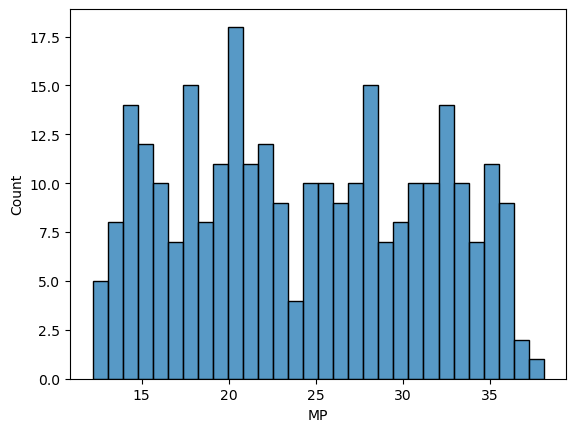

In [16]:
sns.histplot(nbadata['MP'], bins=30)

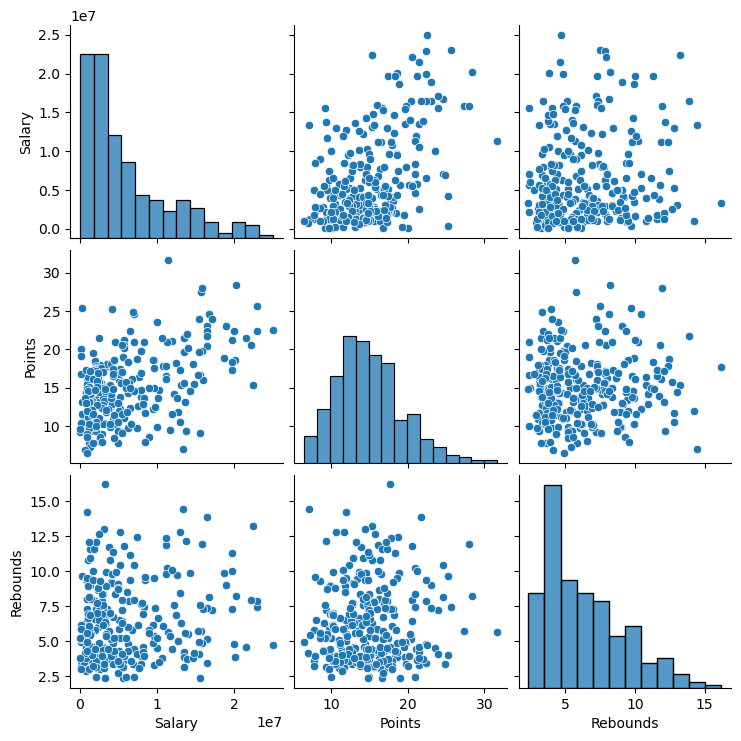

In [17]:
sns.pairplot(taskdata)
plt.show()

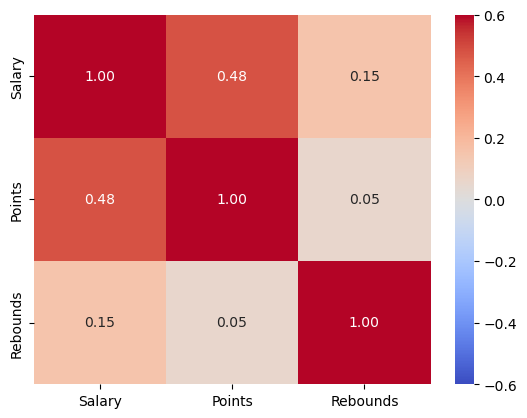

In [18]:
sns.heatmap(taskdata.iloc[:,1:].corr(), annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.show()

In [19]:
def non_dominated(objectives):
    pop_size = np.shape(objectives)[0]
    non_dominated = np.zeros(pop_size, dtype=bool)
    for i in range(pop_size):
        dominated = np.zeros(pop_size, dtype=bool)
        for j in range(pop_size):
            dominated[j]= np.all(objectives[i,:] < objectives[j,:])
        non_dominated[i] = ~np.any(dominated)
    return non_dominated
            


In [20]:
def initializePopulation(nplayers,salary_cap,pop_size, team_size):
    pop_count = 0
    population = np.zeros((pop_size, team_size), dtype=int)
    while pop_count < pop_size:
        sample = rng.choice(nplayers,team_size ,replace = False).astype(int)
        if np.sum(taskdata.iloc[sample,1].values) <= salary_cap:
            population[pop_count,:] = sample
            pop_count += 1
    return population

def evaluatePopulation(population):
    objectives = np.zeros((np.shape(population)[0], taskdata.shape[1]-2))
    for j in range(np.shape(population)[0]):
        team = population[j,:]
        objectives[j,:] = np.sum(taskdata.iloc[team, 2:].values, axis=0)
    return objectives
def samplePopulation(distribution, salary_cap,pop_size, team_size):
    pop_count = 0
    population = np.zeros((pop_size, team_size), dtype=int)
    nplayers = np.size(distribution)
    # Ensure that the population is sampled without replacement
    while pop_count < pop_size:
        sample = rng.choice(nplayers, team_size, p = distribution,replace=False).astype(int)
        if np.sum(taskdata.iloc[sample,1].values) <= salary_cap:
            population[pop_count,:] = sample
            pop_count += 1
    return population


In [21]:
salary_cap = 150_000_000
nplayers = len(nbadata)
team_size = 15
pop_size = 1000
training_size = 10

#population = initializePopulation(nplayers, salary_cap, pop_size, team_size)
distribution = np.ones(nplayers)/nplayers
population = samplePopulation(distribution, salary_cap, pop_size, team_size) 
objectives = evaluatePopulation(np.array(population))
pareto = non_dominated(objectives)
pareto_front = objectives[pareto,:]
pareto_teams = population[pareto,:]
distribution = np.ones(nplayers)
distribution += np.bincount(pareto_teams.flatten(), minlength=nplayers)
distribution /= np.sum(distribution)
for j in range(training_size):
    #sample a new population
    population = samplePopulation(distribution, salary_cap, pop_size, team_size)
    objectives = evaluatePopulation(np.array(population))
    objectives = np.vstack((pareto_front, objectives))
    population = np.vstack((pareto_teams, population))
    pareto = non_dominated(objectives)
    pareto_front = objectives[pareto,:]
    pareto_teams = population[pareto,:]
    distribution = np.ones(nplayers)
    distribution += np.bincount(pareto_teams.flatten(), minlength=nplayers)
    distribution /= np.sum(distribution)




In [22]:
print("Pareto front size:", np.shape(pareto_front)[0])

Pareto front size: 11


In [23]:
print(pareto_front)

[[298.71566977 103.53917338]
 [298.91477643 101.97227124]
 [296.40001019 125.36677844]
 [283.89805078 136.34931678]
 [232.82568547 149.07653009]
 [253.89078642 148.68415083]
 [261.46393052 144.56209658]
 [277.47421249 140.02473779]
 [297.06315277 111.30066183]
 [303.78749167  99.53302201]
 [286.43025311 131.01386698]]


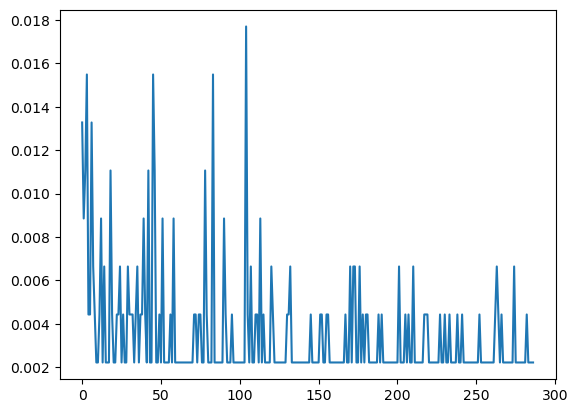

In [24]:
plt.plot(distribution)